In [1]:
import os
import argparse
import time
import math
import shutil
import contextlib
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.optim as optim
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
import torch.utils.data as data
import torchvision.transforms as transforms

from utils.converter import LabelConverter, IndexConverter
from datasets.dataset import InMemoryDigitsDataset, DigitsDataset, collate_train, collate_dev, inmemory_train, inmemory_dev
from generate import gen_text_img

import models
from models.crnn import init_network
from models.densenet_ import DenseNet

import warnings
warnings.filterwarnings("always")


# from tensorboardX import SummaryWriter
# writer = SummaryWriter('./d9ata/runs')
model_names = sorted(name for name in models.__dict__
    if name.islower() and not name.startswith("__")
    and callable(models.__dict__[name]))
optimizer_names = ["sgd", "adam", "rmsprop"]

def parse_args():
    '''Parse input arguments.'''
    parser = argparse.ArgumentParser(description='Digit Recognition')
    parser.add_argument('--dataset-root', default='./data',
                        help='train dataset path')
    parser.add_argument('--arch', default='mobilenetv2_cifar', choices=model_names,
                        help='model architecture: {} (default: mobilenetv2_cifar)'.format(' | '.join(model_names)))
    parser.add_argument('--gpu-id', type=int, default=-1,
                        help='gpu called when train')
    parser.add_argument('--alphabet', default='0123456789',
                        help='label alphabet, string format or file')
    parser.add_argument('--optimizer', default='rmsprop', choices=optimizer_names,
                        help='optimizer options: {} (default: rmsprop)'.format(' | '.join(optimizer_names)))
    parser.add_argument('--max-epoch', type=int, default='30',
                        help='number of total epochs to run (default: 30)')
    parser.add_argument('--not-pretrained', dest='pretrained', action='store_false',
                        help='initialize model with random weights (default: pretrained on cifar10)')
    parser.add_argument('--validate-interval', type=int, default=1,
                        help='Interval to be displayed')
    parser.add_argument('--save-interval', type=int, default=1,
                        help='save a model')
    parser.add_argument('--workers', default=4, type=int,
                        help='number of data loading workers (default: 4)')
    parser.add_argument('--batch-size', type=int, default=64,
                        help='batch size to train a model')
    parser.add_argument('--train-samples', default=640000, type=int,
                        help='train sample number')
    parser.add_argument('--image-size', type=int, default=32,
                        help='maximum size of longer image side used for training (default: 32)')
    parser.add_argument('--lr', type=float, default=1e-3,
                        help='initial learning rate (default: 1e-3)')
    parser.add_argument('--decay-rate', type=float, default=0.1,
                        help='learning rate decay')
    parser.add_argument('--momentum', type=float, default=0.9,
                        help='momentum')
    parser.add_argument('--weight-decay', type=float, default=5e-4,
                        help='weight decay (default: 5e-4)')
    parser.add_argument('--print-freq', type=int, default=10,
                        help='print frequency (default: 10)')
    parser.add_argument('--directory', metavar='EXPORT_DIR', default='./checkpoint',
                        help='Where to store samples and models')
    parser.add_argument('--rnn', action='store_true',
                        help='Train the model with model of rnn')
    parser.add_argument('--resume', default='', type=str, metavar='FILENAME',
                        help='name of the latest checkpoint (default: None)')
    parser.add_argument('--test-only', action='store_true',
                        help='test only')
    args = parser.parse_args()
    return args

In [2]:
def train(train_loader, model, criterion, optimizer, epoch):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()

    # switch to train mode
    model.train()

    end = time.time()

    for i, sample in enumerate(train_loader):
        # Measure data loading time
        data_time.update(time.time() - end)

        # Zero out gradients so we can accumulate new ones over batches
        optimizer.zero_grad()

        # step 2. Get our inputs targets ready for the network.
        # targets is a list of `torch.IntTensor` with `batch_size` size.
        target_lengths = sample.target_lengths.to(device)
        targets = sample.targets # Expected targets to have CPU Backend

        # step 3. Run out forward pass.
        images = sample.images
        if isinstance(images, tuple):
            targets = targets.to(device)
            log_probs = []
            for image in images:
                image = image.unsqueeze(0).to(device)
                log_prob = model(image).squeeze(1)
                log_probs.append(log_prob)
            input_lengths = torch.IntTensor([i.size(0) for i in log_probs]).to(device)
            log_probs = pad_sequence(log_probs)
        else: # Batch
            images = images.to(device)
            log_probs = model(images)
            log_probs = pad_sequence(log_probs)
            input_lengths = torch.full((images.size(0),), log_probs.size(0), dtype=torch.int32, device=device)

        # step 4. Compute the loss, gradients, and update the parameters
        # by calling optimizer.step()
        loss = criterion(log_probs, targets, input_lengths, target_lengths)
        losses.update(loss.item())
        loss.backward()

        # do one step for multiple batches
        # accumulated gradients are used
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if (i+1) % args.print_freq == 0 or i == 0 or (i+1) == len(train_loader):
            print('>> Train: [{0}][{1}/{2}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})'.format(
                   epoch+1, i+1, len(train_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses))

    return losses.avg


In [3]:
def validate(dev_loader, model, epoch, converter):
    batch_time = AverageMeter()
    accuracy = AverageMeter()

    # switch to evaluate mode
    model.eval()

    num_correct = 0
    num_verified = 0
    end = time.time()

    #for i, (images, targets) in enumerate(dev_loader):
    for i, sample in enumerate(dev_loader):
        images = sample.images
        targets = sample.targets
        if isinstance(images, tuple):
            preds = []
            for image in images:
                image = image.unsqueeze(0).to(device)
                log_prob = model(image)
                preds.append(converter.best_path_decode(log_prob, strings=False))
        else: # Batch
            images = images.to(device)
            log_probs = model(images)
            preds = converter.best_path_decode(log_probs, strings=False)

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        num_verified += len(targets)
        for pred, target in zip(preds, targets):
            print(pred)
            print(target)
            if pred == target:
                num_correct += 1
        accuracy.update(num_correct / num_verified)

        if (i+1) % args.print_freq == 0 or i == 0 or (i+1) == len(dev_loader):
            print('>> Val: [{0}][{1}/{2}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Accu {accuracy.val:.3f}'.format(
                   epoch+1, i+1, len(dev_loader), batch_time=batch_time, accuracy=accuracy))

    return accuracy.val


In [4]:
def save_checkpoint(state, is_best, directory):
    filename = os.path.join(directory, '{}_epoch_{}.pth.tar'.format(state['arch'], state['epoch']))
    with contextlib.suppress(FileNotFoundError):
        os.remove(filename)
    torch.save(state, filename)
    if is_best:
        print('>>>> save best model at epoch: {}'.format(state['epoch']))
        filename_best = os.path.join(directory, '{}_best.pth.tar'.format(state['arch']))
        with contextlib.suppress(FileNotFoundError):
            os.remove(filename_best)
        shutil.copyfile(filename, filename_best)


class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def set_batchnorm_eval(m):
    classname = m.__class__.__name__
    if classname.find('BatchNorm') != -1:
        # freeze running mean and std:
        # we do training one image at a time
        # so the statistics would not be per batch
        # hence we choose freezing (ie using imagenet statistics)
        m.eval()
        # # freeze parameters:
        # # in fact no need to freeze scale and bias
        # # they can be learned
        # # that is why next two lines are commented
        # for p in m.parameters():
            # p.requires_grad = False

In [5]:
import sys
# alphabet/alphabet_decode_5990.txt
sys.argv = ['main.py','--dataset-root','alphabet','--arch','densenet121','--alphabet','alphabet/alphabet_decode_5990.txt',
            '--lr','5e-5','--max-epoch','100','--optimizer','rmsprop','--gpu-id','-1','--not-pretrained']

In [6]:
global args, device

args = parse_args()

if args.gpu_id < 0:
    device = torch.device("cpu")
else:
    os.environ["CUDA_VISIBLE_DEVICES"] = str(args.gpu_id)
    device = torch.device("cuda")
    torch.backends.cudnn.benchmark = True

# create export dir if it doesnt exist
directory = "{}".format(args.arch)
directory += "_{}_lr{:.1e}_wd{:.1e}".format(args.optimizer, args.lr, args.weight_decay)
directory += "_bsize{}_imsize{}".format(args.batch_size, args.image_size)

args.directory = os.path.join(args.directory, directory)
print(">> Creating directory if it does not exist:\n>> '{}'".format(args.directory))
if not os.path.exists(args.directory):
    os.makedirs(args.directory)

# initialize model
if args.pretrained:
    print(">> Using pre-trained model '{}'".format(args.arch))
else:
    print(">> Using model from scratch (random weights) '{}'".format(args.arch))

# load alphabet from file
if os.path.isfile(args.alphabet):
    alphabet = ''
    with open(args.alphabet, mode='r', encoding='utf-8') as f:
        for line in f.readlines():
            alphabet += line.strip()
    args.alphabet = alphabet

model = DenseNet(img_height=32, drop_rate=0.2, num_classes=len(args.alphabet) + 1)

transform = transforms.Compose([
    transforms.Resize((32, 280)),
    transforms.ToTensor(),
])

>> Creating directory if it does not exist:
>> './checkpoint/densenet121_rmsprop_lr5.0e-05_wd5.0e-04_bsize64_imsize32'
>> Using model from scratch (random weights) 'densenet121'


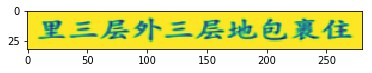

In [7]:
from datasets.dataset import InMemoryDigitsDataset, DigitsDataset, collate_train, collate_dev, inmemory_train, inmemory_dev

num = 100
dev_num = int(num/5)
use_file = 1
text_length = 10
font_size = 0
font_id = 1
space_width = 1
text_color = '#282828'
thread_count = 8

random_skew = False
skew_angle = 0
random_blur = False
blur = 0

distorsion = 0
background = 1

text_meta, text_img = gen_text_img(num, use_file, text_length, font_size, font_id, space_width, background, text_color,
                          blur, random_blur, distorsion, skew_angle, random_skew, thread_count)
dev_meta, dev_img = gen_text_img(dev_num, use_file, text_length, font_size, font_id, space_width, background, text_color,
                          blur, random_blur, distorsion, skew_angle, random_skew, thread_count)

index_converter = IndexConverter(args.alphabet, ignore_case=False)

train_dataset = InMemoryDigitsDataset(mode='train',text=text_meta,img=text_img,total=num,
                                      transform=transform, converter = index_converter)
dev_dataset = InMemoryDigitsDataset(mode='dev', text=dev_meta, img=dev_img, total=dev_num,
                                    transform=transform, converter = index_converter)

train_loader = data.DataLoader(train_dataset, batch_size=args.batch_size, collate_fn=collate_train,
                               shuffle=True, num_workers=args.workers, pin_memory=True)
dev_loader = data.DataLoader(dev_dataset, batch_size=args.batch_size, collate_fn=collate_dev,
                             shuffle=False, num_workers=args.workers, pin_memory=True)

# for i in range(100):
#     img, label = train_dataset.__getitem__(i)
#     print(img.shape,label)
plt.imshow(train_dataset.__getitem__(0)[0][0])


In [8]:

criterion = nn.CTCLoss()
# criterion = nn.CTCLoss(zero_infinity=True)
criterion = criterion.to(device)
# define optimizer
if args.optimizer == 'sgd':
    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum, weight_decay=args.weight_decay)
elif args.optimizer == 'rmsprop':
    optimizer = optim.RMSprop(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)
elif args.optimizer == 'adam':
    optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)

converter = LabelConverter(args.alphabet, ignore_case=False)

# define learning rate decay schedule
# TODO: maybe pass as argument in future implementation?
exp_decay = math.exp(-0.1)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=exp_decay)
# step_decay = 1
# gamma_decay = 0.5
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_decay, gamma=gamma_decay)

is_best = False
best_accuracy = 0.0
accuracy = 0.0
start_epoch = 0

for epoch in range(start_epoch, args.max_epoch):
    # aujust learning rate for each epoch
    scheduler.step()

    # train for one epoch on train set
    loss = train(train_loader, model, criterion, optimizer, epoch)

    # evaluate on validation set
    if (epoch + 1) % args.validate_interval == 0:
        with torch.no_grad():
            accuracy = validate(dev_loader, model, epoch, converter)

    # # evaluate on test datasets every test_freq epochs
    # if (epoch + 1) % args.test_freq == 0:
    #     with torch.no_grad():
    #         test(args.test_datasets, model)

    # remember best accuracy and save checkpoint
    is_best = accuracy > 0.0 and accuracy >= best_accuracy
    best_accuracy = max(accuracy, best_accuracy)

    if (epoch + 1) % args.save_interval == 0:
        save_checkpoint({
            'arch': args.arch,
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'best_accuracy': best_accuracy,
            'optimizer' : optimizer.state_dict(),
        }, is_best, args.directory)


>> Train: [1][1/2]	Time 7.165 (7.165)	Data 0.098 (0.098)	Loss -2.8411 (-2.8411)
>> Train: [1][2/2]	Time 4.003 (5.584)	Data 0.001 (0.049)	Loss -2.5131 (-2.6771)
[1268]
[1, 945, 561, 9, 1795, 75, 162, 29, 1505, 994]
[1268, 5038, 1268, 5038, 1268, 5038, 1268, 5038, 1268]
[31, 230, 3, 760, 733, 266, 1, 93, 456, 61]
[1268, 5038, 1268, 5038, 1268, 5038]
[153, 554, 153, 365, 56, 1131, 34, 54, 161, 4]
[1268, 5038, 1268, 5038, 1268, 5038, 1268, 5038, 1268, 5038, 1268, 5038, 1268]
[2, 34, 153, 504, 868, 528, 188, 168, 79, 161]
[1268, 5038, 1268, 5038, 1268]
[162, 142, 754, 143, 142, 754, 56, 530, 2649, 607]
[5038, 1268, 5038, 1268, 5038]
[27, 153, 895, 6, 45, 32, 165, 544, 3, 32]
[5038, 1268, 5038, 1268, 5038, 1268, 5038]
[456, 61, 912, 188, 168, 32, 1058, 5, 774, 1]
[1268, 5038, 1268, 5038, 1268]
[1676, 350, 1124, 561, 66, 719, 69, 3, 416, 259]
[5038, 1268, 5038, 1268, 5038, 1268, 5038]
[315, 234, 5, 28, 2746, 1042, 74, 40, 471, 3]
[5038, 1268, 5038, 1268, 5038]
[505, 183, 188, 168, 920, 1411, 

Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/opt/conda/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/opt/conda/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/opt/conda/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/opt/conda/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/opt/conda/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/opt/conda/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._h

KeyboardInterrupt: 